In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('../../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# 1. Импорт необходимых библиотек

In [2]:

from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import seaborn as sns
sns.set(style="whitegrid")


#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()


     |████████████████████████████████| 64 kB 1.3 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


**Столбы**

* ***image_name*** - уникальный идентификатор, указывает на имя соответствующего образа DICOM
* ***patient_id*** - уникальный идентификатор пациента
* ***sex*** - пол пациента (когда неизвестно, будет пустым)
* ***age_approx*** - приблизительный возраст пациента на момент визуализации
* ***anatom_site_general_challenge*** - расположение места съемки
* ***diagnosis*** - подробная информация о диагнозе (только поезд)
* ***benign_malignant*** - индикатор злокачественного поражения на снимке
* ***target*** - бинаризованная версия целевой переменной

# 2. Чтение наборов данных изображения

In [3]:
print(os.listdir("../input/siim-isic-melanoma-classification"))

['sample_submission.csv', 'jpeg', 'tfrecords', 'train.csv', 'test.csv', 'test', 'train']


In [4]:
# Определение канала передачи данных
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"

train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')


# обучающих данных
print('Форма тренировочных данных: ', train_df.shape)
train_df.head(5)

Форма тренировочных данных:  (33126, 8)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
train_df.groupby(['benign_malignant']).count()['sex'].to_frame()

,sex
benign_malignant,
benign,32477
malignant,584


# 3. EDA

## отсутствующие значения

In [6]:
# Нулевые значения и типы данных
print('Train Set')
print(train_df.info())
print('-------------')
print('Test Set')
print(test_df.info())

Train Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB
None
-------------
Test Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------             

## Общее количество изображений

In [7]:
# Общее число изображений в наборе данных (train+test)
print("Всего изображений в Поезд набор: ",train_df['image_name'].count())
print("Всего изображений в Тестовый набор: ",test_df['image_name'].count())

Всего изображений в Поезд набор:  33126
Всего изображений в Тестовый набор:  10982


## уникальных ID

In [8]:
print(f"Общее число идентификаторов пациента {train_df['patient_id'].count()}, из тех уникальных идентификаторов являются {train_df['patient_id'].value_counts().shape[0]} ")

Общее число идентификаторов пациента 33126, из тех уникальных идентификаторов являются 2056 


Число уникальных пациентов меньше, чем общее число пациентов. Это означает, что, пациенты имеют несколько записей.

In [9]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']


## Изучение целевого столбца

In [10]:
train_df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

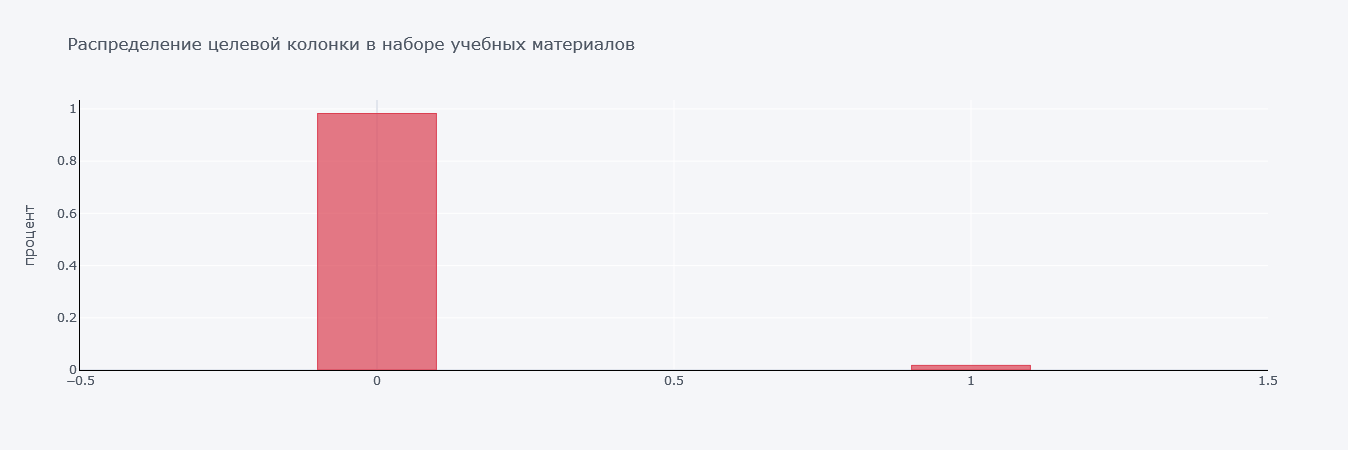

In [11]:
train_df['target'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='процент', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',
                                                     
                                                      title='Распределение целевой колонки в наборе учебных материалов')

## Гендерное распределение


In [12]:
train_df['sex'].value_counts(normalize=True)

male      0.516621
female    0.483379
Name: sex, dtype: float64

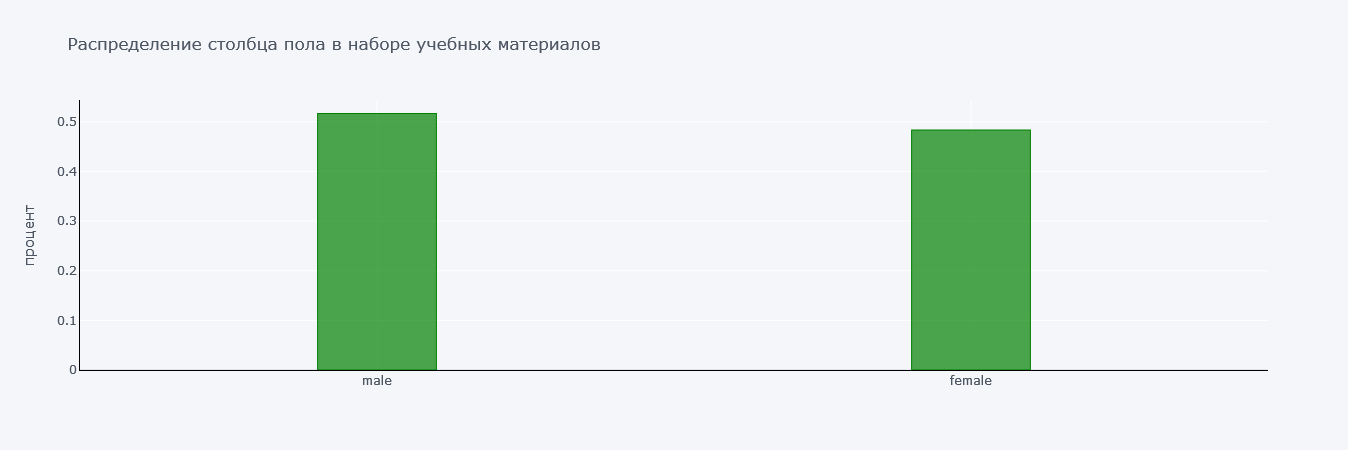

In [13]:
train_df['sex'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='процент', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='green',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',
                                                     
                                                      title='Распределение столбца пола в наборе учебных материалов')

## Гендерный фактор и целевые показатели

In [14]:
z=train_df.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')  

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


Text(0.5, 33.120000000000005, 'доброкачественный:0 против злокачественного:1')

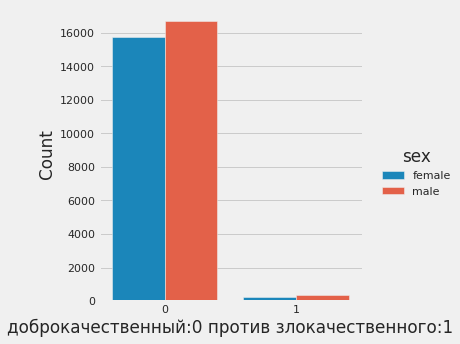

In [16]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')
plt.ylabel('Count')
plt.xlabel('доброкачественный:0 против злокачественного:1')

## Местоположение места съемки

In [17]:
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values()

oral/genital       0.003804
palms/soles        0.011503
head/neck          0.056904
upper extremity    0.152857
lower extremity    0.258198
torso              0.516734
Name: anatom_site_general_challenge, dtype: float64

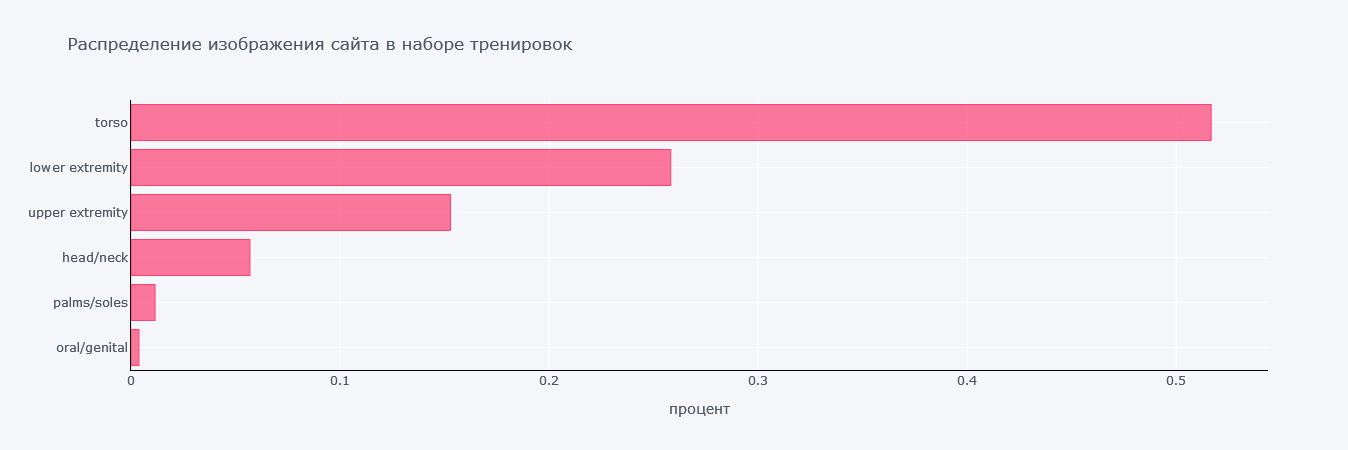

In [19]:
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values().iplot(kind='barh',
                                                      xTitle='процент', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='#FC4072',
                                                      theme='pearl',
                                                      bargap=0.2,
                                                      gridcolor='white',
                                                      title='Распределение изображения сайта в наборе тренировок')

## Местоположение отснятого сайта по полу

Text(48.30606002604168, 0.5, 'количество случаев меланомы')

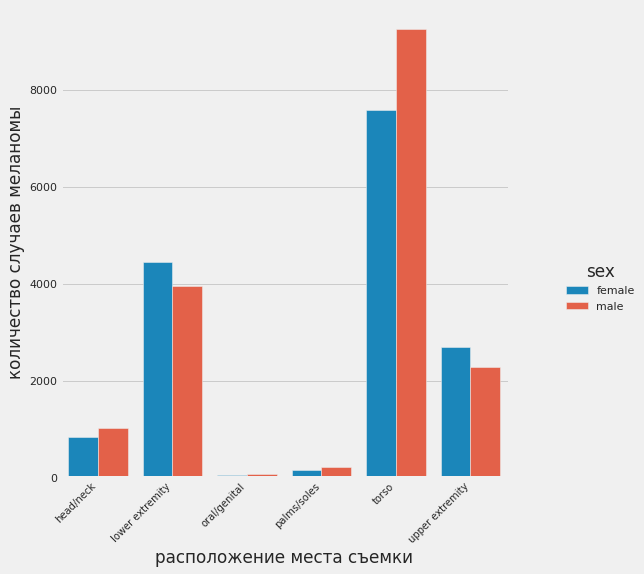

In [20]:

z1=train_df.groupby(['sex','anatom_site_general_challenge'])['benign_malignant'].count().to_frame().reset_index()
z1.style.background_gradient(cmap='Reds')
sns.catplot(x='anatom_site_general_challenge',y='benign_malignant', hue='sex',data=z1,kind='bar')
plt.gcf().set_size_inches(10,8)
plt.xlabel('расположение места съемки')
plt.xticks(rotation=45,fontsize='10', horizontalalignment='right')
plt.ylabel('количество случаев меланомы')


## Age Distribution of patients

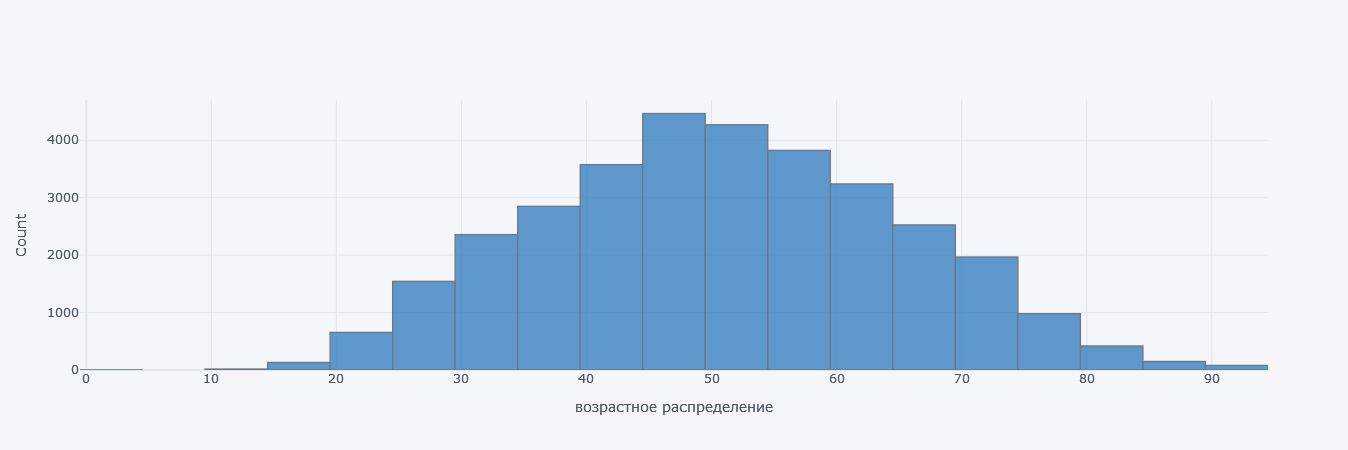

In [23]:
train_df['age_approx'].iplot(kind='hist',bins=30,color='blue',xTitle='возрастное распределение',yTitle='Count')

## Визуализация возраста KDEs
Обобщение данных с помощью графиков плотности для определения местонахождения массы данных.

### Распределение возрастных групп населения

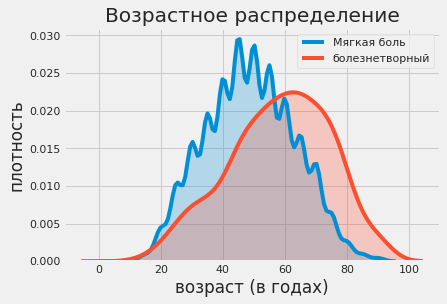

In [24]:
# График возраста KDE, который был диагностирован как доброкачественный
sns.kdeplot(train_df.loc[train_df['target'] == 0, 'age_approx'], label = 'Мягкая боль',shade=True)

# График возраста KDE, который был диагностирован как злокачественный
sns.kdeplot(train_df.loc[train_df['target'] == 1, 'age_approx'], label = 'болезнетворный',shade=True)

# Маркировка участка
plt.xlabel('возраст (в годах)'); plt.ylabel('плотность'); plt.title('Возрастное распределение');


### Распределение возрастов по признаку пола

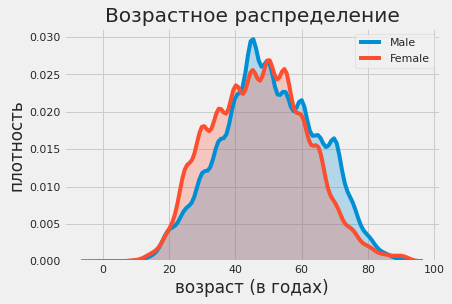

In [25]:
# График возраста KDE, который был диагностирован как доброкачественный
sns.kdeplot(train_df.loc[train_df['sex'] == 'male', 'age_approx'], label = 'Male',shade=True)

# График возраста KDE, который был диагностирован как злокачественный
sns.kdeplot(train_df.loc[train_df['sex'] == 'female', 'age_approx'], label = 'Female',shade=True)

# Маркировка участка
plt.xlabel('возраст (в годах)'); plt.ylabel('плотность'); plt.title('Возрастное распределение');


## Распределение диагноза

In [26]:
train_df['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

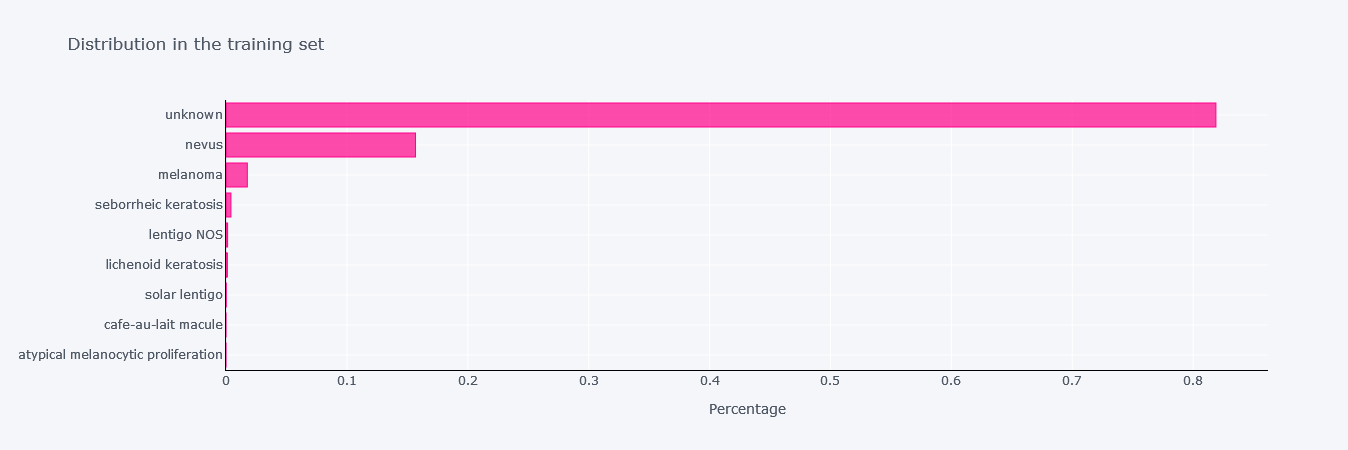

In [28]:
train_df['diagnosis'].value_counts(normalize=True).sort_values().iplot(kind='barh',
                                                      xTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='pink',
                                                      theme='pearl',
                                                      bargap=0.2,
                                                      gridcolor='white',
                                                      title='Distribution in the training set')

## Наложение пациента 
Мы должны проверить, что одинаковые изображения поражения пациента не должны появляться как на тренировках, так и на тестах.

In [29]:
# Извлечь идентификатор пациента для тренировочного набора
ids_train = train_df.patient_id.values
# Извлечь идентификатор пациента для набора проверки
ids_test = test_df.patient_id.values

# Создание "набора" структуры данных идентификатора тренировочного набора для идентификации уникальных идентификаторов
ids_train_set = set(ids_train)
print(f'Есть {len(ids_train_set)} уникальный идентификатор пациента в комплекте тренировок')
# Создание "набора" структуры данных идентификатора проверочного набора для идентификации уникальных идентификаторов
ids_test_set = set(ids_test)
print(f'Есть {len(ids_test_set)} уникальный идентификатор пациента в комплекте тренировок')

# Определите наложение пациента, взглянув на пересечение между наборами
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(f'Есть {n_overlap} Идентификаторы пациентов в наборах как для тренировок, так и для тестов')
print('')
print(f'Эти пациенты содержатся как в учебных, так и в тестовых наборах данных:')
print(f'{patient_overlap}')

Есть 2056 уникальный идентификатор пациента в комплекте тренировок
Есть 690 уникальный идентификатор пациента в комплекте тренировок
Есть 0 Идентификаторы пациентов в наборах как для тренировок, так и для тестов

Эти пациенты содержатся как в учебных, так и в тестовых наборах данных:
[]


# 4. Визуализация изображений : JPEG

## Визуализация случайного выбора изображений

Отображение случайных изображений


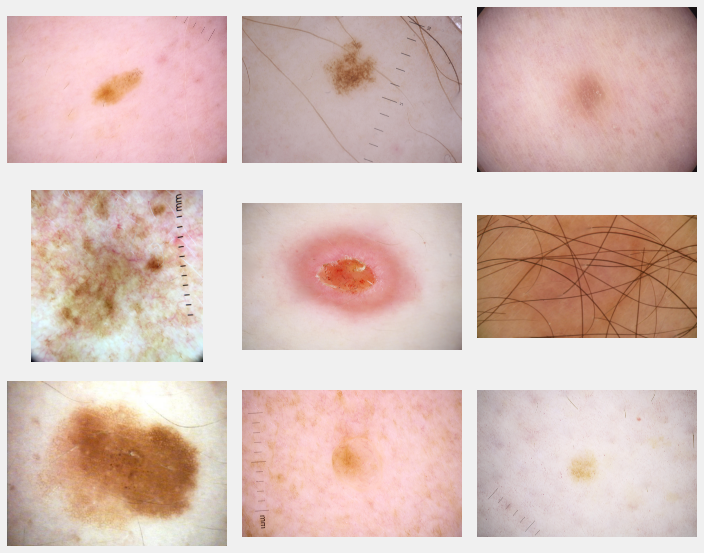

In [30]:
images = train_df['image_name'].values

# Извлечь 9 случайных изображений из него
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Расположение директории изображения
img_dir = IMAGE_PATH+'/jpeg/train'

print('Отображение случайных изображений')

# Настройка размера ваших изображений
plt.figure(figsize=(10,8))

# Итерация и построение случайных изображений
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Настройка параметров подплота для указания указанной набивки
plt.tight_layout()   

## Визуализация изображений с доброкачественными поражениями

In [31]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

Дисплей доброкачественные изображения


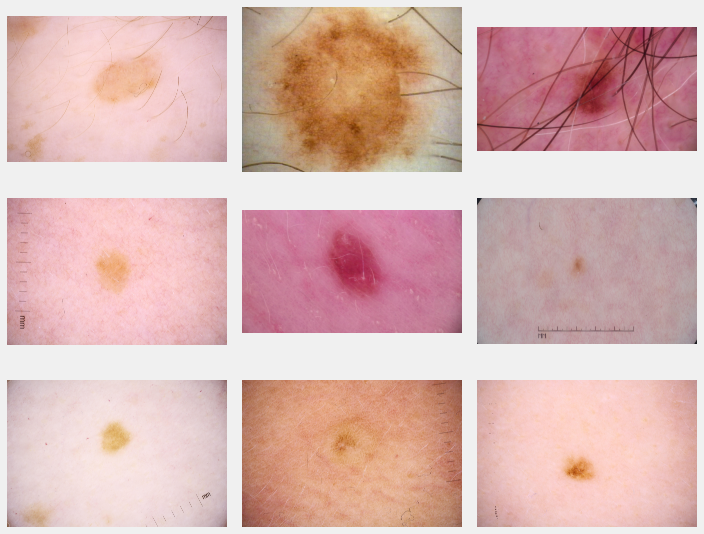

In [32]:
images = benign['image_name'].values

# Извлечь 9 случайных изображений из него
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Расположение директории изображения
img_dir = IMAGE_PATH+'/jpeg/train'

print('Дисплей доброкачественные изображения')

# Настройка размера ваших изображений
plt.figure(figsize=(10,8))

# Итерация и построение случайных изображений
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Настройка параметров подплота для указания указанной набивки
plt.tight_layout()   

## Визуализация изображений со злокачественными поражениями

Отображение злокачественных изображений


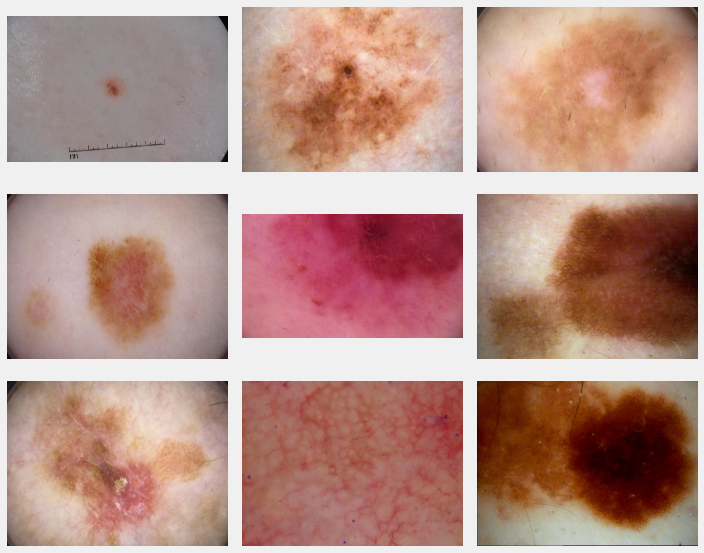

In [33]:
images = malignant['image_name'].values

# Извлечь 9 случайных изображений из него
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Расположение директории изображения
img_dir = IMAGE_PATH+'/jpeg/train'

print('Отображение злокачественных изображений')

# Настройка размера ваших изображений
plt.figure(figsize=(10,8))

# Итерация и построение случайных изображений
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Настройка параметров подплота для указания указанной набивки
plt.tight_layout()   

## гистограммы

### Доброкачественная категория

Размеры изображения:  (4000, 6000)
Максимальное значение пикселя : 255.0 ; Минимальное значение пикселя:0.0
Среднее значение значений пикселей : 169.9 ; стандартное отклонение : 41.3


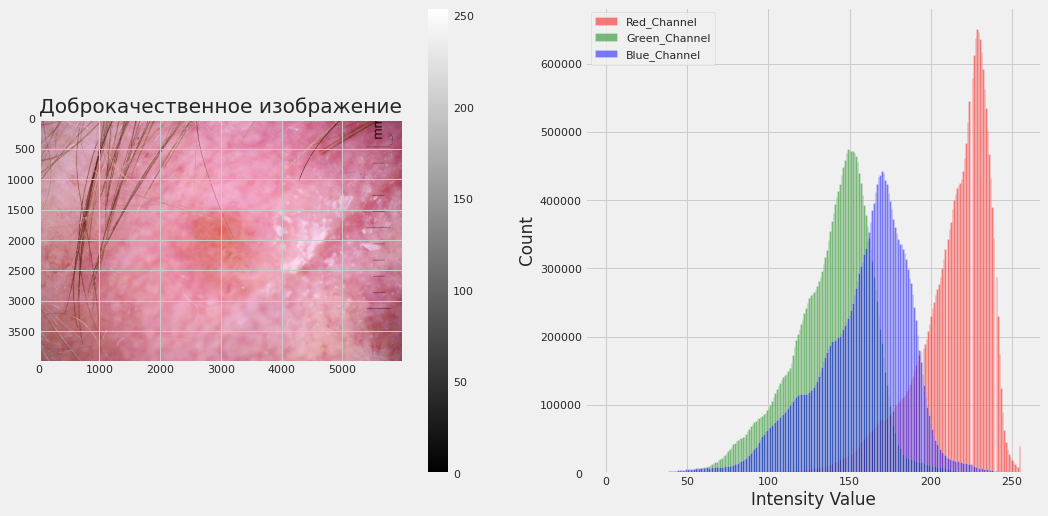

In [34]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = benign['image_name'][0]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Доброкачественное изображение')
print(f"Размеры изображения:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Максимальное значение пикселя : {raw_image.max():.1f} ; Минимальное значение пикселя:{raw_image.min():.1f}")
print(f"Среднее значение значений пикселей : {raw_image.mean():.1f} ; стандартное отклонение : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

### Злокачественная категория

Размеры изображения:  (2448, 3264)
Максимальное значение пикселя : 255.0 ; Минимальное значение пикселя:0.0
Среднее значение значений пикселей : 161.0 ; Стандартное отклонение : 45.1


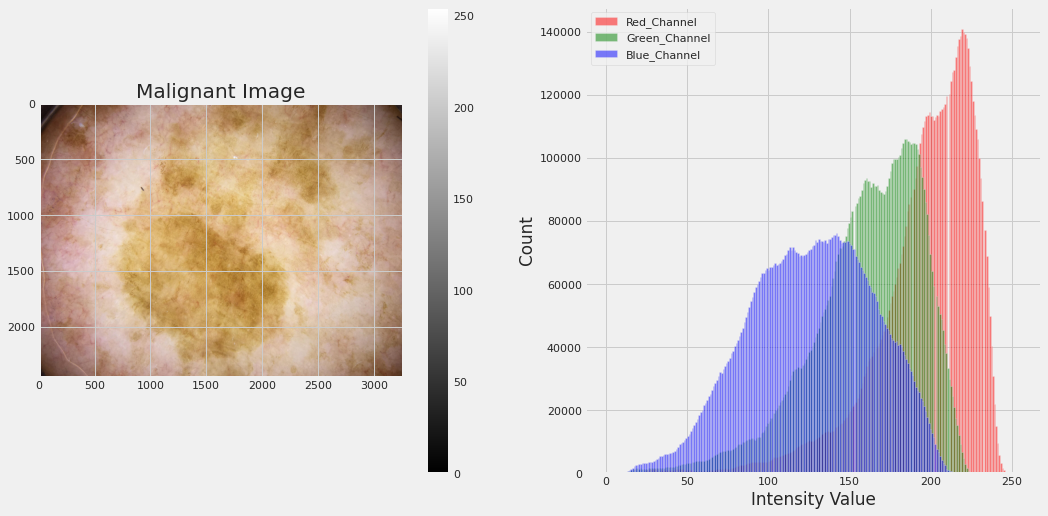

In [35]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = malignant['image_name'][235]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Размеры изображения:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Максимальное значение пикселя : {raw_image.max():.1f} ; Минимальное значение пикселя:{raw_image.min():.1f}")
print(f"Среднее значение значений пикселей : {raw_image.mean():.1f} ; Стандартное отклонение : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

In [36]:
print (pydicom.__version__)

1.4.2


In [41]:
# https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data
def show_dcm_info(dataset):
    print("Имя файла.........:", file_path)
    print("Тип хранения.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Имя пациента......:", display_name)
    print("Идентификатор пациента..........:", dataset.PatientID)
    print("Возраста пациента.......:", dataset.PatientAge)
    print("Пол пациента.......:", dataset.PatientSex)
    print("Модальность............:", dataset.Modality)
    print("Изученная часть тела..:", dataset.BodyPartExamined)
   
    
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Размер изображения.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Расстояние между пикселями....:", dataset.PixelSpacing)

Имя файла.........: ../input/siim-isic-melanoma-classification/train/ISIC_9691303.dcm
Тип хранения.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Имя пациента......: "ISIC, 9691303"
Идентификатор пациента..........: "ISIC_9691303"
Возраста пациента.......: 055Y
Пол пациента.......: F
Модальность............: "XC"
Изученная часть тела..: TORSO
Размер изображения.......: 1053 x 1872, 1463190 bytes


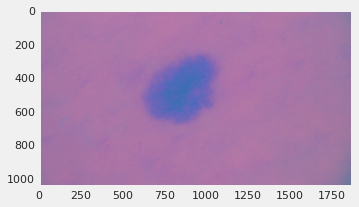

Имя файла.........: ../input/siim-isic-melanoma-classification/train/ISIC_0276167.dcm
Тип хранения.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Имя пациента......: "ISIC, 0276167"
Идентификатор пациента..........: "ISIC_0276167"
Возраста пациента.......: 070Y
Пол пациента.......: M
Модальность............: "XC"
Изученная часть тела..: LOWER EXTREMITY
Размер изображения.......: 4000 x 6000, 1463892 bytes


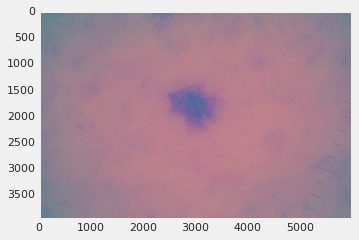

Имя файла.........: ../input/siim-isic-melanoma-classification/train/ISIC_3349751.dcm
Тип хранения.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Имя пациента......: "ISIC, 3349751"
Идентификатор пациента..........: "ISIC_3349751"
Возраста пациента.......: 035Y
Пол пациента.......: M
Модальность............: "XC"
Изученная часть тела..: UPPER EXTREMITY
Размер изображения.......: 1053 x 1872, 1485168 bytes


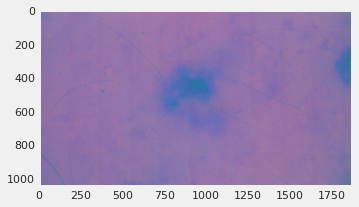

Имя файла.........: ../input/siim-isic-melanoma-classification/train/ISIC_2407132.dcm
Тип хранения.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Имя пациента......: "ISIC, 2407132"
Идентификатор пациента..........: "ISIC_2407132"
Возраста пациента.......: 035Y
Пол пациента.......: F
Модальность............: "XC"
Изученная часть тела..: UPPER EXTREMITY
Размер изображения.......: 4000 x 6000, 1811342 bytes


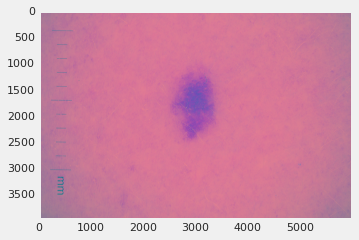

Имя файла.........: ../input/siim-isic-melanoma-classification/train/ISIC_4919596.dcm
Тип хранения.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Имя пациента......: "ISIC, 4919596"
Идентификатор пациента..........: "ISIC_4919596"
Возраста пациента.......: 060Y
Пол пациента.......: F
Модальность............: "XC"
Изученная часть тела..: UPPER EXTREMITY
Размер изображения.......: 1053 x 1872, 1500972 bytes


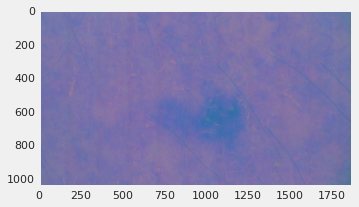

In [42]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array)
    plt.show()
    
i = 1
num_to_plot = 5
for file_name in os.listdir('../input/siim-isic-melanoma-classification/train/'):
        file_path = os.path.join('../input/siim-isic-melanoma-classification/train/',file_name)
        dataset = pydicom.dcmread(file_path)
        show_dcm_info(dataset)
        plot_pixel_array(dataset)
    
        if i >= num_to_plot:
            break
    
        i += 1

In [43]:
folder='train'
PATH='../input/siim-isic-melanoma-classification/'

def extract_DICOM_attributes(folder):
    images = list(os.listdir(os.path.join(PATH, folder)))
    df = pd.DataFrame()
    for image in images:
        image_name = image.split(".")[0]
        dicom_file_path = os.path.join(PATH,folder,image)
        dicom_file_dataset = pydicom.read_file(dicom_file_path)
        study_date = dicom_file_dataset.StudyDate
        modality = dicom_file_dataset.Modality
        age = dicom_file_dataset.PatientAge
        sex = dicom_file_dataset.PatientSex
        body_part_examined = dicom_file_dataset.BodyPartExamined
        patient_orientation = dicom_file_dataset.PatientOrientation
        photometric_interpretation = dicom_file_dataset.PhotometricInterpretation
        rows = dicom_file_dataset.Rows
        columns = dicom_file_dataset.Columns

        df = df.append(pd.DataFrame({'image_name': image_name, 
                        'dcm_modality': modality,'dcm_study_date':study_date, 'dcm_age': age, 'dcm_sex': sex,
                        'dcm_body_part_examined': body_part_examined,'dcm_patient_orientation': patient_orientation,
                        'dcm_photometric_interpretation': photometric_interpretation,
                        'dcm_rows': rows, 'dcm_columns': columns}, index=[0]))
    return df

In [44]:
extract_DICOM_attributes('train')

,image_name,dcm_modality,dcm_study_date,dcm_age,dcm_sex,dcm_body_part_examined,dcm_patient_orientation,dcm_photometric_interpretation,dcm_rows,dcm_columns
0,ISIC_9691303,"""XC""",20200519,055Y,F,TORSO,,YBR_FULL_422,1053,1872
0,ISIC_0276167,"""XC""",20200520,070Y,M,LOWER EXTREMITY,,YBR_FULL_422,4000,6000
0,ISIC_3349751,"""XC""",20200519,035Y,M,UPPER EXTREMITY,,YBR_FULL_422,1053,1872
0,ISIC_2407132,"""XC""",20200519,035Y,F,UPPER EXTREMITY,,YBR_FULL_422,4000,6000
0,ISIC_4919596,"""XC""",20200519,060Y,F,UPPER EXTREMITY,,YBR_FULL_422,1053,1872
...,...,...,...,...,...,...,...,...,...,...
0,ISIC_8157843,"""XC""",20200520,030Y,F,TORSO,,YBR_FULL_422,2448,3264
0,ISIC_5709772,"""XC""",20200519,060Y,F,HEAD/NECK,,YBR_FULL_422,4000,6000
0,ISIC_0347263,"""XC""",20200519,045Y,F,UPPER EXTREMITY,,YBR_FULL_422,4000,6000
0,ISIC_1738297,"""XC""",20200519,060Y,M,HEAD/NECK,,YBR_FULL_422,4000,6000


In [45]:
to_save = extract_DICOM_attributes('train')

In [48]:
# Save the dataframe to a CSV file
to_save.to_csv('Abodo_Brice_Modul_3_Multi-Different.csv', index=False)

## Принцип связки мультимодельных данных:

Принцип связки мультимодельных данных заключается в объединении данных из различных источников, представляющих разные аспекты одного и того же объекта или явления. Это позволяет получить более полное и точное представление о рассматриваемом объекте или явлении.

Существует несколько различных методов связки мультимодельных данных. Один из наиболее простых методов заключается в объединении данных в единую таблицу. Для этого необходимо определить общие атрибуты, по которым можно сопоставить данные из разных источников.

Другой метод связки мультимодельных данных заключается в использовании методов машинного обучения. Например, можно использовать метод кластеризации для объединения данных в группы, представляющие различные аспекты одного и того же объекта или явления.

Еще один метод связки мультимодельных данных заключается в использовании методов визуализации. Например, можно использовать метод тепловых карт для отображения взаимосвязи между данными из разных источников.

Выбор метода связки мультимодельных данных зависит от конкретных задач, которые необходимо решить.

Вот несколько примеров использования связки мультимодельных данных:

    В медицине с помощью связки мультимодельных данных можно объединить данные из различных медицинских источников, таких как медицинские карты, результаты лабораторных исследований и изображения. Это позволяет врачам получить более полное представление о состоянии здоровья пациента и принять более обоснованные решения.
    В маркетинге с помощью связки мультимодельных данных можно объединить данные из различных источников, таких как данные о продажах, данные о поведении клиентов и данные о социальных сетях. Это позволяет компаниям лучше понять своих клиентов и разработать более эффективные маркетинговые стратегии.
    В промышленности с помощью связки мультимодельных данных можно объединить данные из различных источников, таких как данные о производстве, данные о качестве продукции и данные о поведении клиентов. Это позволяет компаниям улучшить качество своей продукции, повысить эффективность производства и увеличить продажи.

Связка мультимодельных данных является мощным инструментом, который может использоваться в различных областях. Она позволяет получить более полное и точное представление о рассматриваемом объекте или явлении, что может привести к улучшению принятия решений и повышению эффективности деятельности.


# Потенциальные применения полученных мультимодальных данных для ранней диагностики, изучения факторов риска и разработки новых методов лечения меланомы

Случай 1: Ранняя диагностика меланомы

    Использование мультимодальных данных для разработки более эффективных алгоритмов машинного обучения для диагностики меланомы. Мультимодальные данные, такие как изображения кожи и клинические данные, могут быть объединены для создания более сложных и точных моделей машинного обучения. Эти модели могут использоваться для классификации изображений кожи как подозрительных или не подозрительных на меланому, что может помочь врачам в ранней диагностике этого опасного заболевания.

    Разработка мобильных приложений для самостоятельного скрининга меланомы. Мультимодальные данные могут быть использованы для разработки мобильных приложений, которые позволяют людям самостоятельно сканировать свою кожу на наличие подозрительных пятен. Эти приложения могут использовать алгоритмы машинного обучения для определения участков кожи, которые требуют дальнейшего изучения врачом.

    Создание баз данных изображений меланомы для обучения и тестирования алгоритмов машинного обучения. Мультимодальные базы данных изображений меланомы могут быть использованы для обучения и тестирования алгоритмов машинного обучения, которые используются для диагностики и лечения этого заболевания. Эти базы данных могут быть использованы для разработки новых алгоритмов и улучшения существующих алгоритмов.

Случай 2: Исследование факторов риска развития меланомы

    Исследование взаимосвязи между мультимодальными данными, такими как образ жизни, генетические факторы и окружающая среда, и риском развития меланомы. Мультимодальные данные могут быть использованы для изучения факторов риска развития меланомы, что может помочь в разработке профилактических мер. Например, исследования могут показать, что люди, которые много времени проводят на солнце, имеют более высокий риск развития меланомы.

    Разработка персонализированных рекомендаций для снижения риска развития меланомы. Мультимодальные данные могут быть использованы для разработки персонализированных рекомендаций для людей, которые находятся в группе риска развития меланомы. Эти рекомендации могут включать советы о том, как снизить воздействие солнца, как защитить кожу от солнечных ожогов и как регулярно проходить обследование кожи.

    Оценка эффективности существующих методов профилактики меланомы. Мультимодальные данные могут быть использованы для оценки эффективности существующих методов профилактики меланомы, таких как скрининг кожи и использование солнцезащитных кремов. Это может помочь в разработке более эффективных методов профилактики.

Случай 3: Разработка новых методов лечения меланомы

    Исследование взаимосвязи между мультимодальными данными, такими как изображения опухолей, геномные данные и данные о клинических испытаниях, и эффективностью новых методов лечения меланомы. Мультимодальные данные могут быть использованы для изучения эффективности новых методов лечения меланомы, таких как иммунотерапия и таргетная терапия. Это может помочь в разработке более эффективных методов лечения.

    Разработка персонализированных подходов к лечению меланомы. Мультимодальные данные могут быть использованы для разработки персонализированных подходов к лечению меланомы, которые учитывают индивидуальные особенности пациента. Например, исследования могут показать, что люди с определенными генетическими вариантами лучше всего реагируют на определенные методы лечения.

    Оценка безопасности и эффективности новых методов лечения меланомы. Мультимодальные данные могут быть использованы для оценки безопасности и эффективности новых методов лечения меланомы. Это может помочь в предотвращении ненужных рисков для пациентов.
